In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    # compute and fill each NaN with the columns mean    
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df[df.columns[df.isnull().any()]].columns)
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7], inplace=True)
    
def score_abs_error(model, data):
    y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy())  )
    y_gold = data["bikes"].to_numpy()
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


In [3]:
# Adding all files into one DataFrame
df = []
for path in Path('./Train/Train').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
#     show_nans(tmp)
    replace_nan(tmp)
    df.append(tmp)

df = pd.concat(df, ignore_index=True)

convert_weekdays(df)

# deleting unneeded columns
del df["month"]
del df["year"]

# comment next line if not dropping NaNs
# df = df.dropna(axis='rows')

# See all Rows/Cols
# pd.set_option('display.max_columns', 23)
pd.set_option('display.max_rows', 23)


scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

print(df.columns)

Index(['station', 'latitude', 'longitude', 'numDocks', 'timestamp', 'day',
       'hour', 'weekday', 'weekhour', 'isHoliday', 'windMaxSpeed.m.s',
       'windMeanSpeed.m.s', 'windDirection.grades', 'temperature.C',
       'relHumidity.HR', 'airPressure.mb', 'precipitation.l.m2',
       'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes',
       'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes'],
      dtype='object')


In [4]:
forest = RandomForestRegressor(n_estimators=500, n_jobs=6)
print("initialised")
forest.fit(df.iloc[:,:-1].to_numpy(), df["bikes"].to_numpy())

importances = forest.feature_importances_
imp_indixes = np.argsort(importances)[::-1]
feature_order = df.columns[:-1][imp_indixes]
importances = importances[imp_indixes]

imp_df = pd.DataFrame(data = importances, index = feature_order, columns=["relative_importance"])


initialised


                             relative_importance
bikes_3h_ago                            0.431118
full_profile_bikes                      0.086483
short_profile_bikes                     0.082086
full_profile_3h_diff_bikes              0.051843
short_profile_3h_diff_bikes             0.051053
hour                                    0.036694
timestamp                               0.030558
numDocks                                0.028380
weekhour                                0.025722
station                                 0.025459
airPressure.mb                          0.022843
longitude                               0.022539
temperature.C                           0.019678
latitude                                0.019029
relHumidity.HR                          0.016903
windMaxSpeed.m.s                        0.011738
windDirection.grades                    0.011735
windMeanSpeed.m.s                       0.007777
day                                     0.007389
isHoliday           

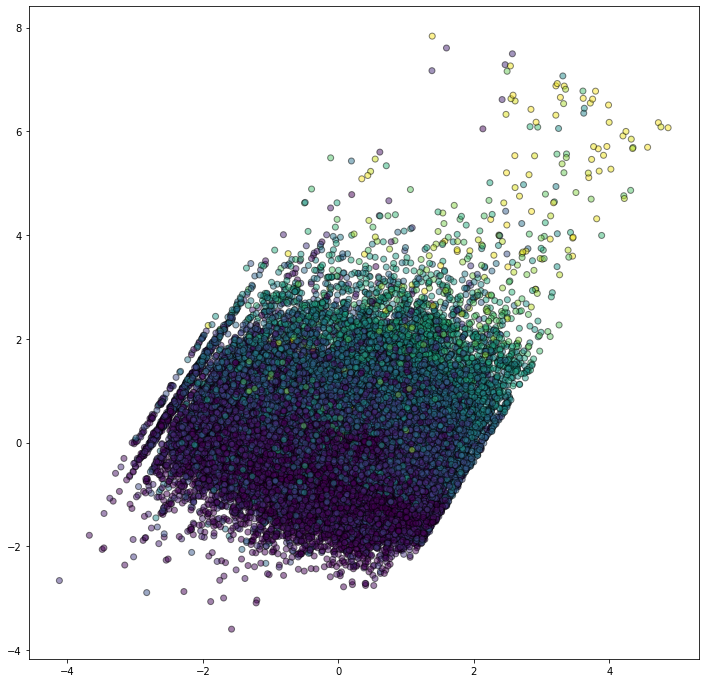

[[1.00000000e+00 4.34026982e-16 2.97087283e-01]
 [4.34026982e-16 1.00000000e+00 5.76032022e-01]
 [2.97087283e-01 5.76032022e-01 1.00000000e+00]]


In [5]:
print(imp_df)
X = df.iloc[:,:-1].to_numpy()
Y = df["bikes"].to_numpy()

from sklearn.decomposition in_estimators=t PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca = PCA(n_components = 2, whiten = True)
X_pca = pca.fit_transform(X)

print(X_pca.shape)

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(X_pca[:,0], X_pca[:,1], c = Y, edgecolor = '0', alpha=0.5)

plt.show()

print(np.corrcoef(X_pca.transpose(), Y))

<AxesSubplot:>

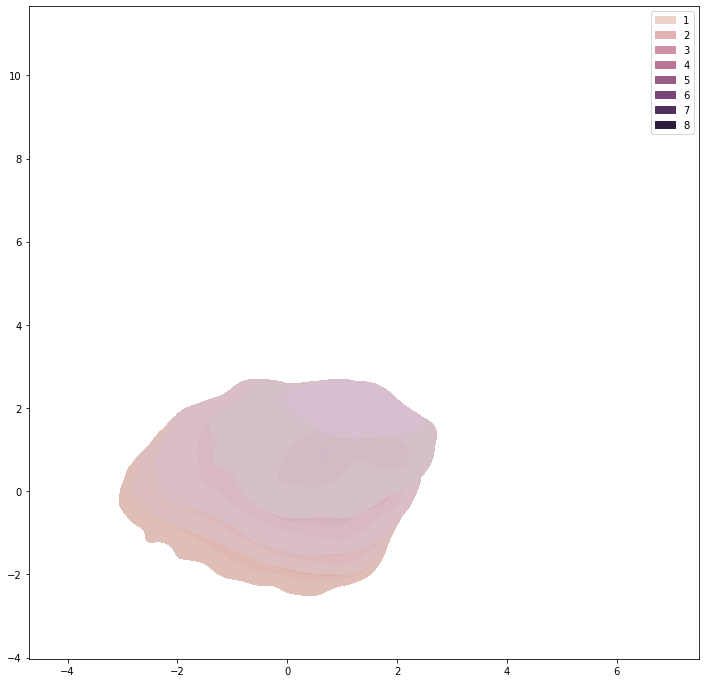

In [6]:
import seaborn as sns

bins = np.linspace(0, np.max(Y), 8)
digitized = np.digitize(Y, bins)
bin_means = [Y[digitized == i].mean() for i in range(1, len(bins))]

fig, ax = plt.subplots(figsize=(12,12))
sns.kdeplot(
    x=X_pca[:,0], y=X_pca[:,1], ax = ax, warn_singular=False, fill = True, hue=digitized
)#
# plt.show()

In [7]:
# plot_features = feature_order[:5].to_list()
# plot_features.append("bikes")
# print(plot_features)

# g = sns.PairGrid(df[plot_features], diag_sharey=False, corner=True)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)


In [8]:


lowest_ranked_10 = feature_order[-5:]
for feature in lowest_ranked_10:
    del df[feature]
print(imp_df.head())





                             relative_importance
bikes_3h_ago                            0.431118
full_profile_bikes                      0.086483
short_profile_bikes                     0.082086
full_profile_3h_diff_bikes              0.051843
short_profile_3h_diff_bikes             0.051053


In [9]:
train, val = train_test_split(df, test_size=0.2)

In [10]:
df

,station,latitude,longitude,numDocks,timestamp,hour,weekhour,windMaxSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,-1.478148,0.078077,0.085531,0.778671,-1.729727,-1.658502,-0.764152,-0.012341,-1.185957,-0.124745,1.140226,-3.458244,-0.158975,-0.000507,-0.209238,-0.000507,-0.209238,0.0
1,-1.478148,0.078077,0.085531,0.778671,-1.725078,-1.514125,-0.742678,-1.132619,-0.146932,-0.185926,1.200060,-0.038999,-0.158975,-0.000507,-0.209238,-0.000507,-0.209238,0.0
2,-1.478148,0.078077,0.085531,0.778671,-1.720428,-1.369747,-0.721203,-1.132619,-0.666444,-0.247106,1.200060,-2.862877,-0.158975,-0.000507,-0.209238,-0.000507,-0.209238,0.0
3,-1.478148,0.078077,0.085531,0.778671,-1.715778,-1.225369,-0.699728,-1.317408,-0.276233,-0.400056,1.319728,-3.352349,-1.138946,-0.000507,-0.209238,-0.000507,-0.209238,0.0
4,-1.478148,0.078077,0.085531,0.778671,-1.711128,-1.080992,-0.678254,-0.578255,-0.146932,-0.430647,1.259894,-2.451061,-1.138946,-0.000507,-0.209238,-0.000507,-0.209238,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55870,-1.385764,-0.149629,-0.120714,2.532435,1.711128,1.084674,0.674650,-0.197129,-1.705470,-0.461237,0.841055,0.499891,0.698655,0.060055,0.467717,0.060055,0.467717,6.0
55871,-1.385764,-0.149629,-0.120714,2.532435,1.715778,1.229051,0.696125,-0.578255,1.931119,-0.461237,0.960723,0.509304,0.239255,-0.547681,-0.164887,-0.547681,-0.164887,7.0
55872,-1.385764,-0.149629,-0.120714,2.532435,1.720428,1.373429,0.717600,-0.947831,1.671363,-0.522417,1.020557,0.511657,-0.220146,-0.426134,-0.255259,-0.426134,-0.255259,6.0
55873,-1.385764,-0.149629,-0.120714,2.532435,1.725078,1.517807,0.739074,-1.317408,-0.276233,-0.736548,1.080391,0.521070,-0.220146,-1.641607,-0.752305,-1.641607,-0.752305,5.0


# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a random forest regressor. It takes a while to run with these parameters.

In [11]:
from time import time
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from scipy.stats import randint

# forest_boost = GradientBoostingRegressor(n_estimators=n_est, loss='squared_error', learning_rate=0.2, max_depth=2, verbose=1)
#  forest_boost = SVR()
searched_boost = RandomForestRegressor()
searched_boost = GradientBoostingRegressor(n_estimators=5000)



param_distributions = {"max_depth":  [2,3,4, 5, 6, None],
                       "min_samples_split": np.around(np.linspace(2,20,19)).astype(np.int32),
                       "learning_rate": np.linspace(0.0001,1,25)
                      }

search = HalvingRandomSearchCV(searched_boost, param_distributions,
                               resource='n_samples', aggressive_elimination=True,
                               factor = 2, n_candidates =  100,
                               random_state=0, verbose=1, n_jobs=6).fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

print(search.best_params_)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 13
min_resources_: 10
max_resources_: 44700
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 100
n_resources: 640
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 50
n_resources: 1280
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 2
n_candidates: 25
n_resources: 2560
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 3
n_candidates: 13
n_resources: 5120
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 4
n_candidates: 7
n_resources: 10240
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 5
n_candidates: 4
n_resources: 20480
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 40960
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'min_samples_split': 9, 'max_depth': 6, 'learn

In [ ]:
start = time()
print("initialised")
forest_boost = GradientBoostingRegressor(max_depth = 4, min_samples_split=9, learning_rate = 0.08, n_estimators = 5000, verbose=1)
forest_boost.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())
print(f'fitted in {time() - start}s')

initialised
      Iter       Train Loss   Remaining Time 
         1          38.6064            9.92m
         2          35.3137            8.65m
         3          32.5028            8.27m
         4          30.0679            8.10m
         5          27.9585            7.96m
         6          26.1541            7.91m
         7          24.5775            7.87m
         8          23.2393            7.82m
         9          22.0581            7.78m
        10          21.0781            7.76m
        20          15.8960            7.54m
        30          14.3120            7.54m
        40          13.5775            7.48m
        50          13.1819            7.44m
        60          12.9161            7.41m
        70          12.7294            7.37m
        80          12.5653            7.35m
        90          12.4399            7.33m
       100          12.3419            7.31m
       200          11.3503            7.09m
       300          10.7436            6.9

In [18]:
print(score_abs_error(forest_boost, val))

2.384309975704217


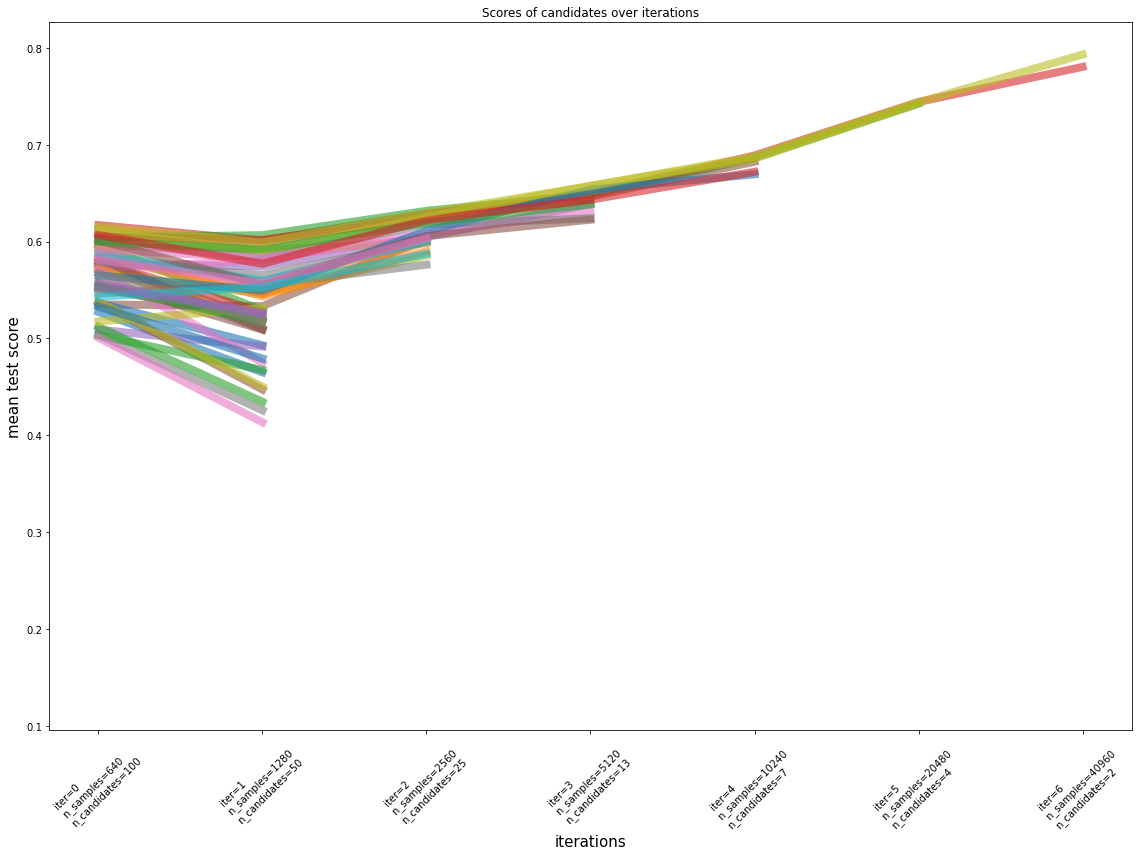

In [14]:


results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
params = search.param_distributions
# results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
learning_rates = params["learning_rate"]
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

fig, ax = plt.subplots(figsize=(16,12))
mean_scores.plot(legend=False, alpha=0.6, ax = ax, linewidth=8)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]} \nn_candidates={search.n_candidates_[i]}"# \nn_estimators={params["n_estimators"][i]} "
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()


In [15]:
try:
    n_est = search.best_params_["n_estimators"]
except:
    n_est = 5000

import matplotlib.pyplot as plt
test_score = np.zeros((n_est,), dtype=np.float64)

y_test = val["bikes"]
#y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
    test_score[i] = forest_boost.loss_(y_test, np.around(y_pred))


fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 1, 1)
plt.title("Training and validation error")
plt.plot(
    np.arange(n_est) + 1,
    forest_boost.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Squared error")
plt.yscale('log')
fig.tight_layout()
plt.show()

KeyError: 'n_estimators'

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(y_test - forest_boost.predict(val.iloc[:,:-1]), bins = 30)
plt.show()

In [ ]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]
del test["month"]
del test["year"]

convert_weekdays(test)
test[test.columns] = scaler.fit_transform(test[test.columns])

for feature in lowest_ranked_10:
    del test[feature]
    
print(test.columns)  
print(train.columns)

#y_pred = forest_boost.predict(test)
y_pred = reasonable_predictions(forest_boost, test)

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("trial.csv")